In [13]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import math

# Tensor
다차원 숫자 배열(n-dimensional array)
- 딥러닝에서 데이터(입력, 가중치, 출력) 를 모두 담고 계산할 때 쓰는 기본 단위
- 벡터, 행렬 연산 가능, GPU에서 빠르게 연산 + 미분 추적 가능
- 저장공간 : CPU or GPU (CUDA) 메모리

그래서 nn.Embedding, Linear, Attention 같은 모든 연산이 Tensor를 요구한다.

In [3]:
# 1️⃣ 토큰화 + 숫자화
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text = "I like coffee in the morning because it helps me wake up and stay focused."
tokens = tokenizer(text, return_tensors="pt") # pt : pytorch, tf : TensorFlow
token_ids = tokens["input_ids"][0]

print("토큰 목록:", tokenizer.tokenize(text))
print("토큰 ID:", token_ids)
for t in token_ids:
    print(f"{t}\t -> {tokenizer.decode([t])}")

토큰 목록: ['i', 'like', 'coffee', 'in', 'the', 'morning', 'because', 'it', 'helps', 'me', 'wake', 'up', 'and', 'stay', 'focused', '.']
토큰 ID: tensor([ 101, 1045, 2066, 4157, 1999, 1996, 2851, 2138, 2009, 7126, 2033, 5256,
        2039, 1998, 2994, 4208, 1012,  102])
101	 -> [CLS]
1045	 -> i
2066	 -> like
4157	 -> coffee
1999	 -> in
1996	 -> the
2851	 -> morning
2138	 -> because
2009	 -> it
7126	 -> helps
2033	 -> me
5256	 -> wake
2039	 -> up
1998	 -> and
2994	 -> stay
4208	 -> focused
1012	 -> .
102	 -> [SEP]


In [4]:
# 2️⃣ 임베딩
vocab_size = tokenizer.vocab_size   # 약 30,000개 단어
d_model = 4                         # 논문 기준은 512

# Embedding : token을 tensor 타입으로 넣어야함. 
embedding = nn.ModuleDict({
        "token_embedding" : nn.Embedding(vocab_size, d_model)
        })

print(embedding.token_embedding)
X = embedding.token_embedding(tokens["input_ids"])  # shape: (1, token_len, d_model)

print("임베딩 벡터 :", X)  # torch
print("임베딩 벡터 크기:", X.shape)  # torch.Size([1, 5, 4])

Embedding(30522, 4)
임베딩 벡터 : tensor([[[ 2.2492, -1.3944,  0.2040, -0.1924],
         [ 0.7997, -1.7156, -0.3025, -0.8182],
         [-0.0262, -0.0891, -0.4609,  0.0057],
         [-0.3356, -1.0266,  0.1259, -0.3407],
         [-1.4034, -0.6887, -0.0271,  1.4614],
         [ 1.2505, -0.4184, -0.8117, -0.8895],
         [ 0.3183, -0.1043,  1.8858, -0.7206],
         [-1.0490,  0.6804,  0.6484, -0.4451],
         [ 1.4509, -0.6827,  1.7155, -0.5030],
         [ 0.3731, -0.6247, -0.1073,  0.6600],
         [ 1.5374,  0.1381, -0.3425, -0.6509],
         [ 0.3339,  0.6796, -0.1684, -1.6892],
         [ 1.4457,  0.4261,  0.2345,  0.2923],
         [ 0.6517, -0.8738,  0.4028, -1.3497],
         [-0.6824, -0.2253,  0.6968, -1.2108],
         [ 1.2347,  0.5405,  0.6361,  1.1549],
         [ 0.6156,  0.4736, -0.2714,  0.1362],
         [ 0.5491,  0.6940, -1.2113, -0.1297]]], grad_fn=<EmbeddingBackward0>)
임베딩 벡터 크기: torch.Size([1, 18, 4])


# Positional Encoding

$$ PE(pos,2i)=sin(\frac{pos} {10000^{2i/d_{model}}}) $$
$$ PE(pos,2i+1)=cos(\frac{pos} {10000^{2i/d_{model}}}) $$


Positional Encoding :  [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]
 [-0.7568025  -0.65364362  0.03998933  0.99920011]
 [-0.95892427  0.28366219  0.04997917  0.99875026]
 [-0.2794155   0.96017029  0.05996401  0.99820054]
 [ 0.6569866   0.75390225  0.06994285  0.997551  ]
 [ 0.98935825 -0.14550003  0.07991469  0.99680171]
 [ 0.41211849 -0.91113026  0.08987855  0.99595273]
 [-0.54402111 -0.83907153  0.09983342  0.99500417]
 [-0.99999021  0.0044257   0.1097783   0.9939561 ]
 [-0.53657292  0.84385396  0.11971221  0.99280864]
 [ 0.42016704  0.90744678  0.12963414  0.99156189]
 [ 0.99060736  0.13673722  0.13954311  0.990216  ]
 [ 0.65028784 -0.75968791  0.14943813  0.98877108]
 [-0.28790332 -0.95765948  0.15931821  0.98722728]
 [-0.96139749 -0.27516334  0.16918235  0.98558477]]
하나의 토큰이 차원마다 가지고 있는 PE 값들
# 각 차원마다 다른 파동 형태를 가지고 있다. 차원이 높

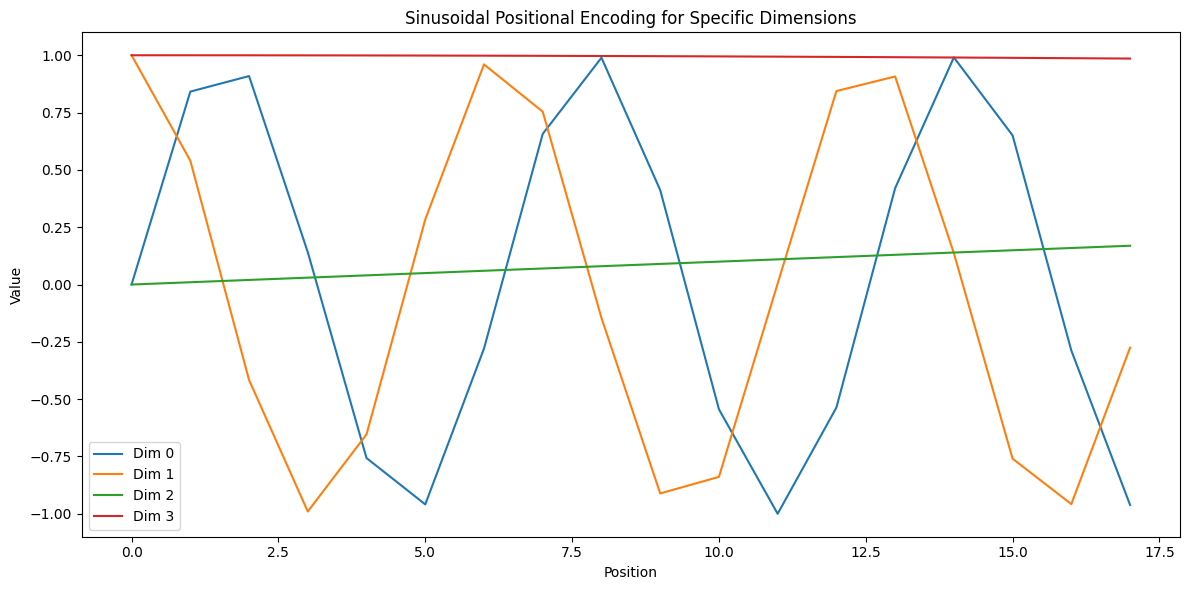

두개의 토큰이 차원마다 가지고 있는 PE 값들
# 해당 PE 값들은 행렬곱을 할 수 있게 만들고
# Attention은 행렬곱(벡터들의 내적 연산)을 통해 상대적 거리를 계산한다.


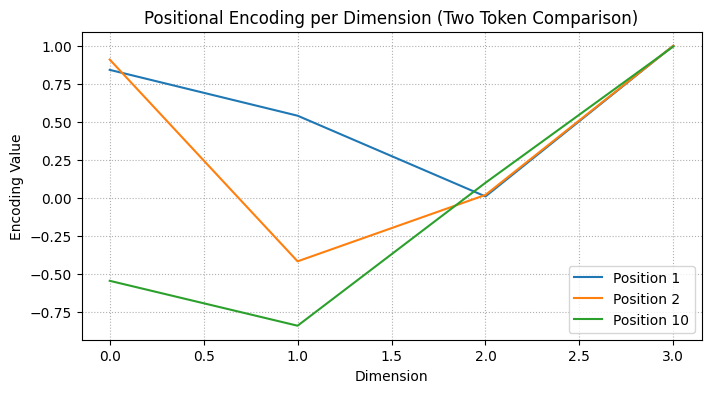

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_position, d_model):
    position = np.arange(max_position)[:, np.newaxis] # [[0], [1], [2], ... , [max_position-1]]
    # The original formula pos / 10000^(2i/d_model) is equivalent to pos * (1 / 10000^(2i/d_model)).
    # I use the below version for numerical stability

    # `np.arange(0, d_model, 2)` : [0, 2, ...] -> 짝수에대한 값. d_model이 4라면 [0, 2]
    # `np.log(10000.0)`          : 로그 변환 
    # `np.exp(...)`              : 지수 함수 (exponential)로 원래 비율 복원
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((max_position, d_model))     # d_model 차원만큼 0으로 초기화된 행렬 생성

    # `0::2` : 짝수 차원 (0, 2, 4, …) -> sin 파형
    # `1::2` : 홀수 차원 (1, 3, 5, …) -> cos 파형
    # `position * div_term` : 각 위치마다 주파수 스케일링 곱
    # 
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    
    return pe

max_position = len(token_ids)#len(tokens["input_ids"])  # Maximum sequence length
d_model = 4        # Embedding dimension

pe = positional_encoding(max_position, d_model)
# [[0,1,2,3], [a,b,c,d], [e,f,g,h], ...] : 4개의 차원이 토큰 개수만큼 존재
# 0번째 토큰의 PE 값들 : [0, a, e, ...]
print("Positional Encoding : ", pe)

# ==========================
# 시각화
# ==========================
print("===========================")
print("하나의 토큰이 차원마다 가지고 있는 PE 값들")
print("# 각 차원마다 다른 파동 형태를 가지고 있다. 차원이 높아질 수록 파동이 느려진다.")
print("# 낮은 차원 = 높은 파동 : 세밀한 위치 변화에 민감 = 가까운 단어 간의 상대적 위치 학습")
print("# 높은 차원 = 낮은 파동 : 완만한 변화, 넓은 범위 인코딩 = 멀리 떨어진 단어의 관계 학습")
print("===========================")
plt.figure(figsize=(12, 6))
for d in range(d_model):
    plt.plot(pe[:, d], label=f'Dim {d}')
plt.legend()
plt.title('Sinusoidal Positional Encoding for Specific Dimensions')
plt.xlabel('Position')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

print("===========================")
print("두개의 토큰이 차원마다 가지고 있는 PE 값들")
print("# 해당 PE 값들은 행렬곱을 할 수 있게 만들고")
print("# Attention은 행렬곱(벡터들의 내적 연산)을 통해 상대적 거리를 계산한다.")
print("===========================")
pos1, pos2, pos10 = 1, 2, 10  # 비교할 두 위치 선택 (예: "coffee" vs "helps")
v1, v2, v10 = pe[pos1], pe[pos2], pe[10]  # 두 벡터 추출

plt.figure(figsize=(8, 4))
plt.plot(v1, label=f'Position {pos1}')
plt.plot(v2, label=f'Position {pos2}')
plt.plot(v10, label=f'Position {pos10}')

plt.title('Positional Encoding per Dimension (Two Token Comparison)')
plt.xlabel('Dimension')
plt.ylabel('Encoding Value')
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


## Positional Encoding + Embedding

In [6]:
pe_tensor = torch.tensor(pe, dtype=X.dtype)
print(X.shape, pe_tensor.shape)
pe_tensor.unsqueeze_(0)  # 배치 차원 추가 -> (1, token_len, d_model)
print(X.shape, pe_tensor.shape)

X_input = X + pe_tensor
print(X_input)

torch.Size([1, 18, 4]) torch.Size([18, 4])
torch.Size([1, 18, 4]) torch.Size([1, 18, 4])
tensor([[[ 2.2492, -0.3944,  0.2040,  0.8076],
         [ 1.6411, -1.1753, -0.2925,  0.1817],
         [ 0.8831, -0.5053, -0.4409,  1.0055],
         [-0.1945, -2.0166,  0.1559,  0.6588],
         [-2.1602, -1.3423,  0.0128,  2.4606],
         [ 0.2916, -0.1347, -0.7618,  0.1093],
         [ 0.0389,  0.8559,  1.9457,  0.2776],
         [-0.3920,  1.4343,  0.7184,  0.5524],
         [ 2.4403, -0.8282,  1.7954,  0.4938],
         [ 0.7852, -1.5359, -0.0175,  1.6560],
         [ 0.9933, -0.7010, -0.2427,  0.3441],
         [-0.6660,  0.6840, -0.0586, -0.6953],
         [ 0.9091,  1.2700,  0.3543,  1.2851],
         [ 1.0718,  0.0336,  0.5324, -0.3582],
         [ 0.3082, -0.0886,  0.8364, -0.2206],
         [ 1.8850, -0.2192,  0.7856,  2.1437],
         [ 0.3277, -0.4840, -0.1121,  1.1235],
         [-0.4123,  0.4189, -1.0421,  0.8559]]], grad_fn=<AddBackward0>)


Attention
$$Attention(Q,K,V)=Softmax(​\frac{​QK^T}{\sqrt{d_k}}​)V$$

$$MultiHead(Q,K,V)=Concat(head_1, ... , head_h)W^o$$

$$\text{where }head_i = Attention(Q{W_i}^Q, K{W_i}^K, V{W_i}^V)

In [7]:
# 입력 토큰 임베딩을 Query 공간으로 선형 변환
w_Q = nn.Linear(d_model, d_model) # y = xW^T + b
w_K = nn.Linear(d_model, d_model)
w_V = nn.Linear(d_model, d_model)

# 선형변환으로 Q, K, V 생성
Q = w_Q(X_input)  # shape: (1, token_len, d_model)
K = w_K(X_input)
V = w_V(X_input)

# Q = Q.view(batch, seq_len, num_heads, head_dim)
# batch : 한번의 학습에서 모델에 동시에 넣는 데이터 묶음. 1개면 토큰 1개, 32개면 토큰 32개.
# num_heads : multi-head attention에서 head의 개수
# default num_heads = 8 or 12,,, 여기선 8로 설정.

print("Q shape:", Q.shape)  # torch.Size([1, token_len, d_model]) : (배치 크기, 토큰 길이, 임베딩 차원) -> Q의 원소 수 : 1 * token_len * d_model
num_heads = 2 # d_model은 반드시 num_heads로 나누어떨어져야 합니다.
head_dim = d_model // num_heads  # 4 // 2 -> 2

# view가 만들어내는 총 원소 수는 batch * seq_len * num_heads * head_dim -> Q의 원소 수와 동일해야한다.
view_Q = Q.view(1, max_position, num_heads, head_dim)  # (batch, token_len, num_heads, head_dim)
view_K = K.view(1, max_position, num_heads, head_dim)
view_V = V.view(1, max_position, num_heads, head_dim)
print("view_Q shape:", view_Q.shape)  # torch.Size([1, token_len, 1, d_model])

# batch -> seq_len -> num_heads -> head_dim 순서를
# batch -> num_heads -> seq_len -> head_dim 순서로 바꿔줘야함.
# Attention 계산에서는 head 별로 병렬 연산을 해줘야하기 때문에 seq_len보다 num_heads가 먼저 있어야하기때문.
transposed_Q = view_Q.transpose(1, 2)
transposed_K = view_K.transpose(1, 2)
transposed_V = view_V.transpose(1, 2)
print("transposed_Q shape:", transposed_Q.shape) 

Q shape: torch.Size([1, 18, 4])
view_Q shape: torch.Size([1, 18, 2, 2])
transposed_Q shape: torch.Size([1, 2, 18, 2])


$$Softmax(​\frac{​QK^T}{\sqrt{d_k}}​)V$$

In [8]:
# QK^T 계산 : 모든 토큰이 다른 토큰과 얼마나 관련 있는지 유사도 계산
# 행렬곱 규칙 : (A[..., m, k]) @ (B[..., k, n]) → (result[..., m, n])
# (seq_len×head_dim)×(head_dim×seq_len)⇒(seq_len×seq_len) 가능하게 하기 위해선 K를 전치해야함.

# 그대로 곱하면 (seq_len×head_dim)×(seq_len×head_dim)이 되므로, Q의 head_dim과 K의 head_dim이 맞지 않기 때문에 K를 전치(transpose)해줘야함.

# Q: (batch, num_heads, seq_len, head_dim)
# Kᵀ: (batch, num_heads, head_dim, seq_len)
scores = torch.matmul(transposed_Q, transposed_K.transpose(-2, -1))
# 결과: (batch, num_heads, seq_len, seq_len) -> (몇개의 문장인지, 몇개의 head인지, Q 토큰 위치, K 토큰 위치)
print("scores shape:", scores.shape)

scores shape: torch.Size([1, 2, 18, 18])


In [11]:
# decoder에서 적용해야되는 부분, scores.masked_fill(0) mask가 True인 위치를 value로 채워 넣어 무시되게 한다. 이전 데이터만 인식할 수 있도록!
mask = torch.tril(torch.ones(max_position, max_position))  # 하삼각행렬 : 행렬의 대각선 아래쪽부분만 1로 남기고 나머지는 0으로 만들게 함.
print(mask)
decoder_scores = scores.masked_fill(mask == 0, float('-inf'))
print(decoder_scores)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1.,

In [14]:

# Q * K^T / sqrt(d_k)
scores = scores / math.sqrt(head_dim)
print("Scaled Scores shape:", scores.shape)

# softmax(Q * K^T / sqrt(d_k))
# softmax 적용 (dim=-1 : 마지막 차원 기준으로 softmax 적용 -> 각 query의 attention weight 합이 1이 되게 만듦)
# attention에선 dim을 -1로 주로 설정함. 이유는 마지막 차원이 key 토큰 위치에 해당하기 때문.
# scores의 마지막 차원은 K 토큰 위치에 해당.
attention_weights = torch.softmax(scores, dim=-1)
print("Attention Weights shape :", attention_weights.shape)

# softmax(Q * K^T / sqrt(d_k)) * V
output = torch.matmul(attention_weights, transposed_V)
print("Output shape:", output.shape)  # (batch, num_heads, seq_len, head_dim)


Scaled Scores shape: torch.Size([1, 2, 18, 18])
Attention Weights shape : torch.Size([1, 2, 18, 18])
Output shape: torch.Size([1, 2, 18, 2])


$$Concat(head_1, ... , head_h)W^o$$

In [15]:
# 1️⃣ (batch, num_heads, seq_len, head_dim)
# contiguous 👉 메모리상에서 텐서를 연속된(continuous) 형태로 다시 정렬(copy)해주는 함수예요. transpose 다음에 view 해주려면 contiguous 해줘야함.
transposed_O = output.transpose(1, 2).contiguous()
#  -> (batch, seq_len, num_heads, head_dim)

batch, num_heads, seq_len, head_dim = output.shape

# 2️⃣ 모든 head를 concat (flatten)
out = transposed_O.view(batch, seq_len, d_model)
#  -> (batch, seq_len, d_model)
print("Final Output shape:", out.shape)  # (batch, seq_len, d_model)

Final Output shape: torch.Size([1, 18, 4])


# Add & Norm (Residual Connection + LayerNorm)
### Residual connection (Add)
→ 입력을 그대로 더해서 “원래 정보”를 보존

→ gradient 흐름이 끊기지 않도록 안정화

### Layer Normalization (Norm)
→ 각 샘플 내부의 feature 차원별로 평균과 분산을 정규화

→ 학습이 더 안정적이고 수렴이 빠름

In [16]:
def add_norm(x, out, d_model) -> torch.Tensor:

    # drop out : 데이터의 특정규칙들을 제외하고 날리는 것.
    drop_out_nd = 0.1 # 드롭아웃 비율, (overffitting 되었다면 0.1보다 더 높게 설정, underffitting 되었다면 0.1보다 더 낮게 설정)

    norm = nn.LayerNorm(d_model)
    dropout = nn.Dropout(drop_out_nd)

    # residual connection : 입력 + 서브레이어 출력
    # dropout : 과적합 방지를 위해 일부 뉴런을 랜덤하게 비활성화 : sublayer 출력에 적용
    # norm() : 합친 결과에 정규화 적용
    residual = norm(x + dropout(out))

    return residual

residual = add_norm(X_input, out, d_model)
print("MultiHeadAttention Add & Norm shape:", type(residual), residual.shape)  # (batch, seq_len, d_model)


MultiHeadAttention Add & Norm shape: <class 'torch.Tensor'> torch.Size([1, 18, 4])


# FeedForward Network
- 각 토큰마다 독립적으로 작동하는 2층 fully-connected layer입니다.

- Attention이 “관계”를 학습했다면, FeedForward는 “비선형 변환(표현 확장)”을 학습합니다.

$$ FFN(x) = \max(0, xW_1 + b_1)W_2 + b_2 $$

In [18]:
drop_out_nd = 0.1
d_ff = 4*d_model # 내부 확장 차원 (보통 2048 = 4×d_model)

net = nn.Sequential(
    nn.Linear(d_model, d_ff),
    nn.ReLU(),
    nn.Dropout(drop_out_nd),
    nn.Linear(d_ff, d_model),
)

net_output = net(residual)
print("FFN Output shape:", net_output.shape)

add_norm(residual, net_output, d_model)
print("FFN Add & Norm shape:", type(residual), residual.shape) 

FFN Output shape: torch.Size([1, 18, 4])
FFN Add & Norm shape: <class 'torch.Tensor'> torch.Size([1, 18, 4])
